# Project 001 UCSD Data Science Visualization Bootcamp
* Noreen Malik 😃
* Rene Venema("dutch") 🐱
* John Warlop 🦁
* Alex Wooten 🏄

😛😳😗😓🙉😸🙈🙊😽💀💢💥✨💏👫👄👃👀👛👛🗼🔮🔮🎄🎅👻

## Dependencies -- imports


In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from sodapy import Socrata #pip install sodapy
import plotly.plotly as py #pip installl plotly
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
import json

## Constants -- API Keys, etc

In [122]:
# Read in API(.gitignore file has entry for api_keys.json file)
API_endpoint = "https://data.cms.gov/resource/spmh-qjdv.json" #2015 data


IRS_DATAFRAME_PICKLE = 'df_irs.pkl'
with open('api_keys.json') as json_data:
    api_keys = json.load(json_data)

# Socrata Section
socrata_domain = "data.cms.gov"
socrata_dataset_identifier = "spmh-qjdv"
socrata_token = api_keys['socrata']['App_Token']

## Functions 


In [123]:
def return_irs_df(file_name):
    #return the pickled dataframe for irs data
    df_irs = pd.read_pickle(file_name)
    return(df_irs)

# IRS Dataframe
[Link to Documentation](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2015-zip-code-data-soi) |
[SOI Tax Stats](https://www.irs.gov/statistics/soi-tax-stats-statistical-methodology) | [Data Cleaning of IRS Data](https://docs.google.com/document/d/1kNd1S_Ufgy0pIjJSjLDHba8y-pK8OYe47iAGeamH04E/edit?usp=sharing)

In [124]:
# Dataframe columns are: ST(State), Zip(Zip Code), AGI(Adjusted Gross Income),\
# TtlR(Total Returns)
# TtlSR(Total Single Returns), TtlJR(Total Joint Returns),\
# Eld(Number of Elderly Returns -- over 60 years old)
# AGI column is agreegated: 
# 1=> [1-25000), 2=> [25000-50000), 3=> [50000-75000), 4=> [75000-100000),
# 5=> [100000,200000), 6=> [200000-]
df_irs = return_irs_df(IRS_DATAFRAME_PICKLE)
df_irs = df_irs.rename(columns={'Zip':'zip'})
# Breakout Each AGI bin into separate dataframe
df_zip_25K = df_irs[df_irs['AGI']==1]
df_zip_50K = df_irs[df_irs['AGI']==2]
df_zip_75K = df_irs[df_irs['AGI']==3]
df_zip_100K = df_irs[df_irs['AGI']==4]
df_zip_200K = df_irs[df_irs['AGI']==5]
df_zip_1M   = df_irs[df_irs['AGI']==6]
df_zip_25K.head(2)

,ST,zip,AGI,TtlR,TtlSR,TtlJR,Eld
0,AL,0,1,836320.0,481570.0,109790.0,149910.0
6,AL,35004,1,1490.0,970.0,230.0,350.0


# Dataframe - Medicare csv/api (dutch)
[Link to Documentation](https://dev.socrata.com/foundry/data.cms.gov/ehrv-m9r6)


In [125]:
x = input("Would you like to re-generate main dataframe(use API key)?")
if x == 'Y':
    client = Socrata(socrata_domain, socrata_token)
    results = client.get(socrata_dataset_identifier, limit = 100000000) #default for limit (integer) = 1000
    main_df = pd.DataFrame.from_dict(results)
    main_df.head()
    # Convert column datatypes
    ## Convert to float
    col1 = ["average_covered_charges","average_medicare_payments","average_total_payments"]
    main_df[col1] = main_df[col1].astype("float")
    ## Convert to integer
    col2 = ["provider_id","provider_zip_code","total_discharges"]
    main_df[col2] = main_df[col2].astype("int")
    # Export data to csv file
    main_df.to_csv("main data cleaned.csv", encoding = "utf-8-sig", index = False)

Would you like to re-generate main dataframe(use API key)?n


In [126]:
# Import data from csv
from collections import Counter
main_df = pd.read_csv("main data cleaned.csv")

# Avg Cost Per Provider (Alex)

In [127]:
"""ACC = Average Covered Charges

The provider's average charge for services covered by Medicare for all discharges in the DRG. 
These will vary from hospital to hospital because of differences in hospital charge structures.

ATP = Average Total Payments

The average of Medicare payments to the provider for the DRG including the 
DRG amount, teaching,  disproportionate share, capital, and outlier payments for all cases. 
Also included are co-payment and deductible amounts that the patient is responsible for (average_medicare_payments)

AMP = Average Medicare Payments

The average amount that Medicare pays to the provider for Medicare's share of the MS-DRG. 
Average Medicare payment amounts include the MS-DRG amount, teaching, disproportionate share, 
capital, and outlier payments for all cases.

Q&A (source: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/Inpatient_Outpatient_FAQ.pdf)

Question

In the Inpatient and Outpatient Charge Data, what is the difference between “Average Charges” 
and “Average Total Payments”?

Answer

“Average Charges” refers to what the provider bills to Medicare. 
“Average Total Payments” refers to what Medicare actually pays to the provider as well as 
co-payment and deductible amounts that the beneficiary is responsible for 
and payments by third parties for coordination of benefits.

Question

Who pays the difference between what the provider charges and Medicare pays?

Answer

The provider has an agreement with Medicare to accept Medicare’s payment and the difference is not 
paid by Medicare or any other entity, including the beneficiary.
"""

# Create a Groupby based on Provider Id and Provider name
# Calculate mean values in ACC, ATP, AMP (or we may just be interested in what
# the patient pays)
# I could also sum up the average value of payments by patient and by insurance
# to see average total value provider charges

cost_df = main_df[["provider_id", "provider_name", "provider_zip_code", "average_covered_charges",
                   "average_total_payments", "average_medicare_payments"]]

provider_group = cost_df.groupby(["provider_id", "provider_name", "provider_zip_code"])
# provider_group = cost_df.groupby(["provider_id", "provider_name"])
avg_cost_group = round(provider_group.mean(),2)
avg_cost_group.columns
# len(avg_cost_group)

Index(['average_covered_charges', 'average_total_payments',
       'average_medicare_payments'],
      dtype='object')

In [128]:
# Most Expensive Hospitals based on out-of-pocket charges

avg_cost_group["average_patient_payment"] = (avg_cost_group["average_total_payments"]-
                                             avg_cost_group["average_medicare_payments"])
avg_cost_group.to_pickle('avg_cost_group.pkl') # For main_plots notebook
# Sort values in descending order and view DataFrame
# avg_cost_group.sort_values(by=["average_patient_payment"], ascending=False).head()

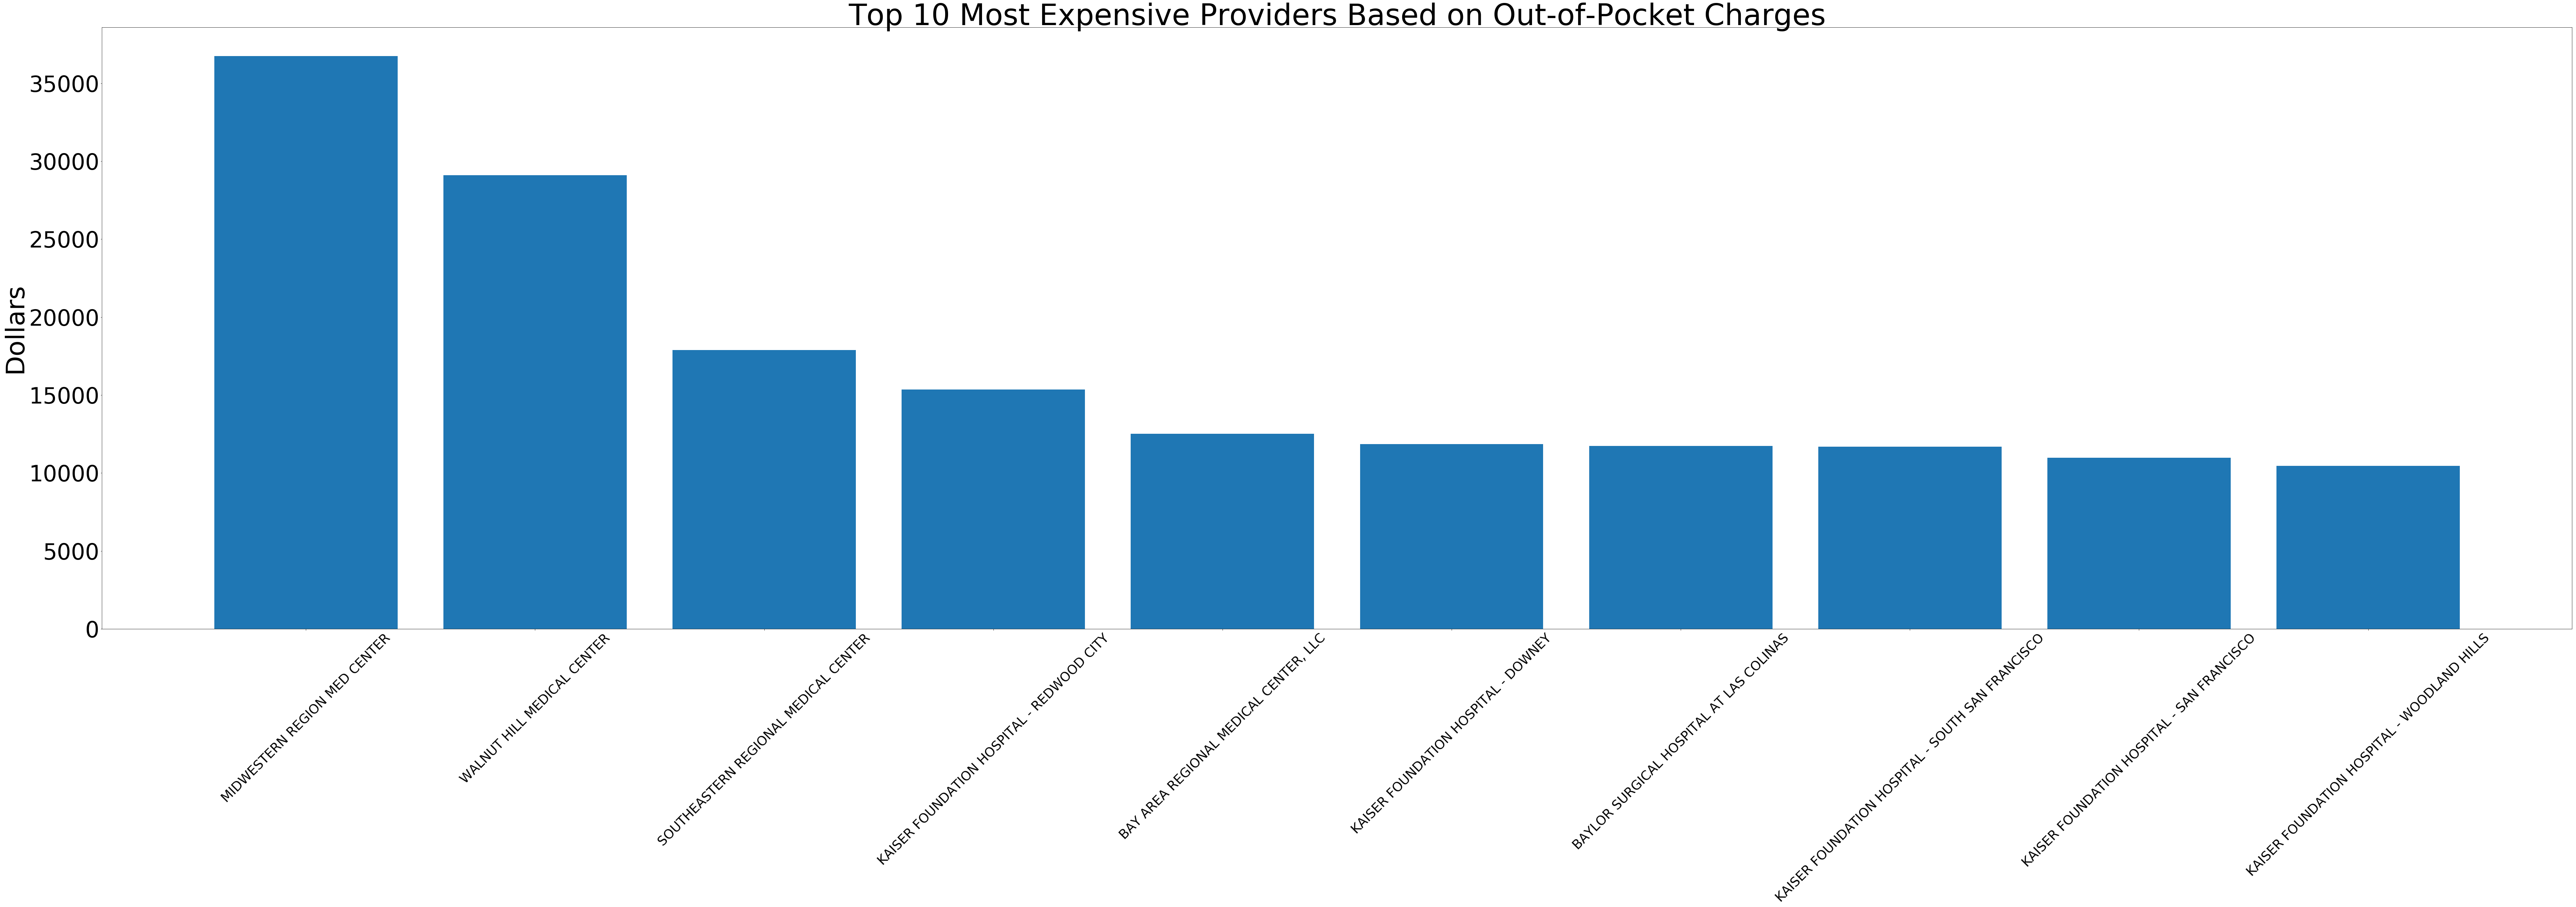

In [129]:
# len(avg_cost_group["average_covered_charges"])
import matplotlib.pyplot as plt
import numpy as np

# get the top 10 most expensive hospitals
plt.figure(1, figsize=(120,30))
x_axis = np.arange(0,10)
top_10_expensive = avg_cost_group["average_patient_payment"].sort_values(ascending=False).head(10)
tick_locations = [value for value in x_axis]
# print(list(top_10_expensive.reset_index()["provider_name"]))
plt.xticks(tick_locations, list(top_10_expensive.reset_index()["provider_name"]), size=35, rotation=45)
plt.yticks(size=60)

plt.ylabel("Dollars", size=70)
plt.title("Top 10 Most Expensive Providers Based on Out-of-Pocket Charges", size=80)

# Show graph
plt.bar(x_axis, top_10_expensive)
plt.show()

<Container object of 10 artists>

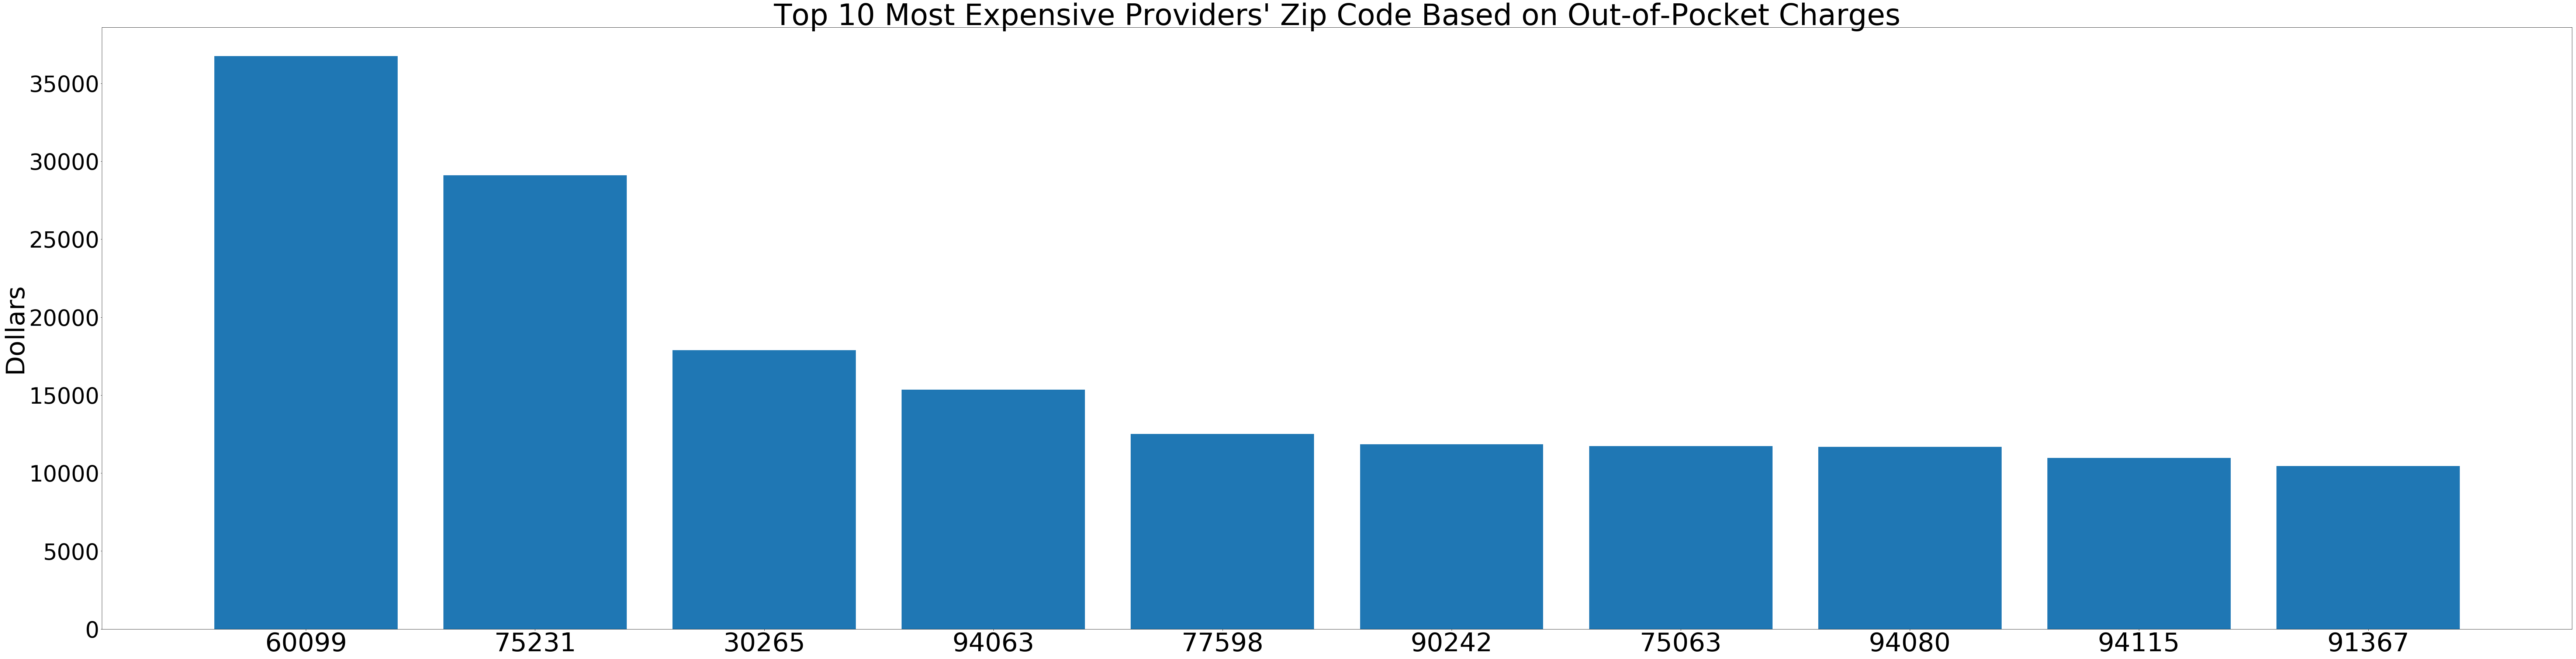

In [130]:
top_10_expensive_zip = avg_cost_group["average_patient_payment"].sort_values(ascending=False).head(10)

plt.figure(2, figsize=(120,30))
x_axis = np.arange(0,10)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, list(top_10_expensive_zip.reset_index()["provider_zip_code"]), size=70)
plt.yticks(size=60)
plt.ylabel("Dollars", size=70)
plt.title("Top 10 Most Expensive Providers' Zip Code Based on Out-of-Pocket Charges", size=80)

# Show graph
plt.bar(x_axis, top_10_expensive)

In [131]:
provider_group2 = cost_df.groupby(["provider_zip_code"])

# Get the mean value of all charges grouped by provider_zip_code, drop provider_id column
# Alex, took this out columns=["provider_id"] and replaced with shown below 4/15 ~John
avg_cost_group2 = round(provider_group2.mean(),2).drop('provider_id',axis=1)

# add average_patient_payment column
avg_cost_group2["average_patient_payment"] = (avg_cost_group2["average_total_payments"]-
                                             avg_cost_group2["average_medicare_payments"])
# View whole DataFrame grouped by zip code in descending order
# avg_cost_group2.sort_values(by=["average_patient_payment"], ascending=False)
avg_cost_group2.to_pickle('avg_cost_group2.pkl') # for main_plots.pkl added 4/16/18 jwarlop

<Container object of 10 artists>

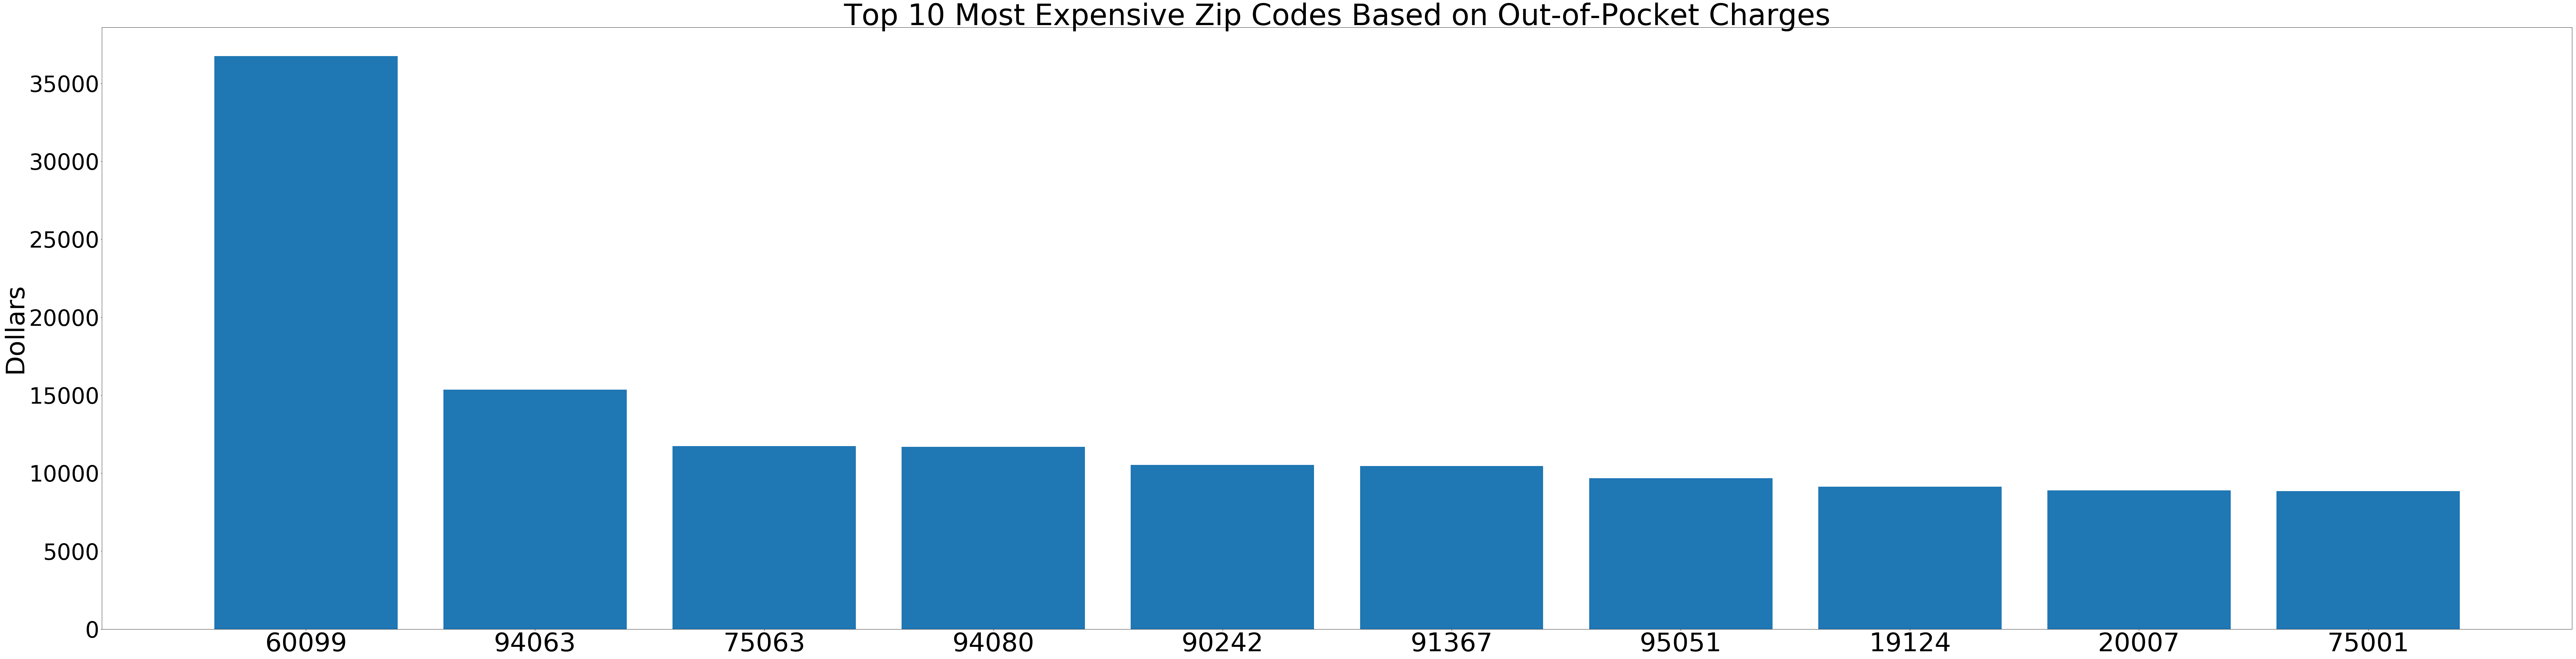

In [132]:
top_10_expensive_zip_avg = avg_cost_group2["average_patient_payment"].sort_values(ascending=False).head(10)

plt.figure(3, figsize=(120,30))
x_axis = np.arange(0,10)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, list(top_10_expensive_zip_avg.reset_index()["provider_zip_code"]), size=70)
plt.yticks(size=60)
plt.ylabel("Dollars", size=70)
plt.title("Top 10 Most Expensive Zip Codes Based on Out-of-Pocket Charges", size=80)

# Show graph
plt.bar(x_axis, top_10_expensive_zip_avg)

In [133]:
cost_df2 = main_df[["hospital_referral_region_hrr_description", "average_covered_charges",
                   "average_total_payments", "average_medicare_payments"]]
cost_df2

provider_group3 = cost_df2.groupby(["hospital_referral_region_hrr_description"])
avg_cost_group3 = round(provider_group3.mean(),2)

# add average_patient_payment column
avg_cost_group3["average_patient_payment"] = (avg_cost_group3["average_total_payments"]-
                                             avg_cost_group3["average_medicare_payments"])
# View DF sorted descending
# avg_cost_group3.sort_values(by=["average_patient_payment"], ascending=False)

<Container object of 10 artists>

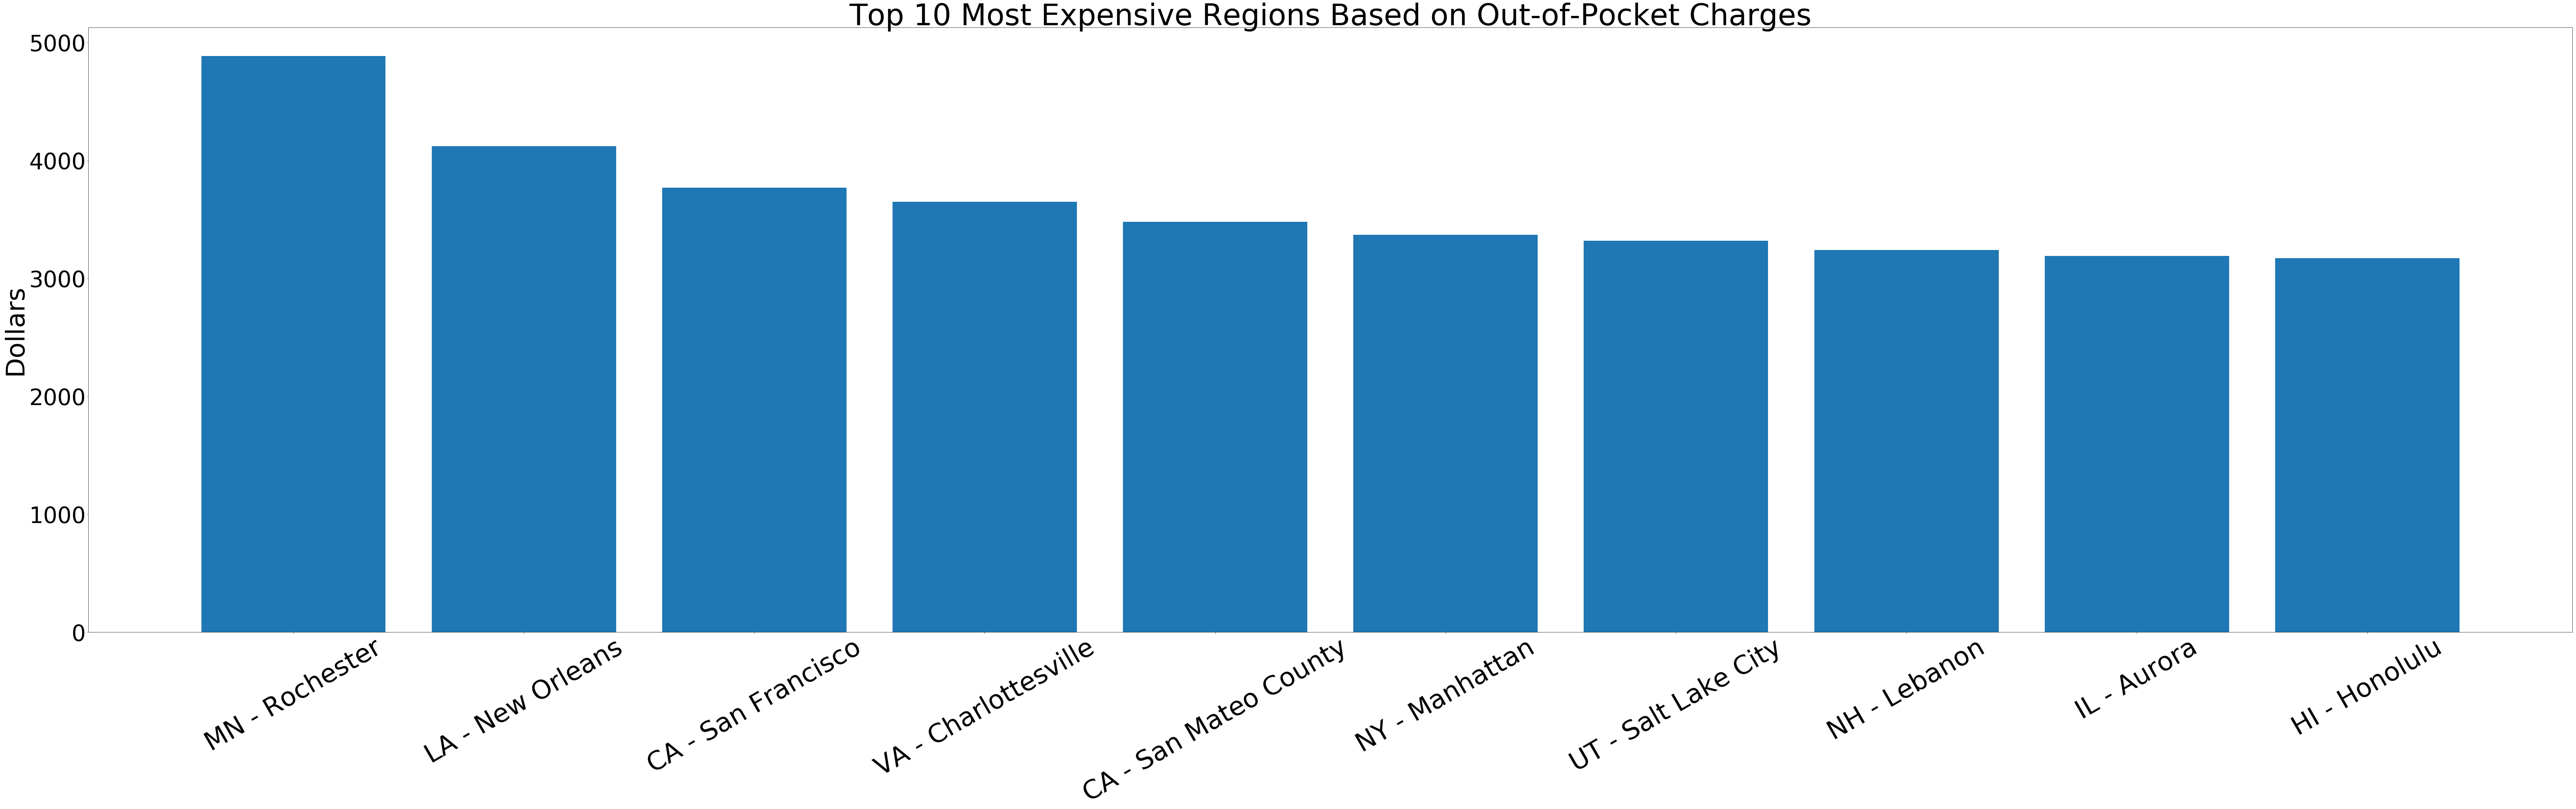

In [134]:
# Bar graph of average out-of-pocket expenses for all hopsitals in a zip code

# Create variable to be used in y-axis sorted descending order
top_10_expensive_region_avg = avg_cost_group3["average_patient_payment"].sort_values(ascending=False).head(10)

plt.figure(4, figsize=(120,30))
x_axis = np.arange(0,10)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, list(top_10_expensive_region_avg.reset_index()["hospital_referral_region_hrr_description"]), 
           size=70, rotation=30)
plt.yticks(size=60)
plt.ylabel("Dollars", size=70)
plt.title("Top 10 Most Expensive Regions Based on Out-of-Pocket Charges", size=80)

# Show graph
plt.bar(x_axis, top_10_expensive_region_avg)

In [135]:
# import "nst-est2017-01.xlsx" state population data
# create DataFrame of population by state
# merge with main_df on "State" (may have to rename state for it to work)
# create scatterplot showing relationship between state population and out-of-pocket costs

In [136]:
# dataframe with the info I am interested in
cost_df3 = main_df[["provider_state", "average_covered_charges",
                   "average_total_payments", "average_medicare_payments"]]
cost_df3
# now groupby:
provider_group4 = cost_df3.groupby(["provider_state"])
avg_cost_group4 = round(provider_group4.mean(),2)

# after groupby and means:
avg_cost_group4["average_patient_payment"] = (avg_cost_group4["average_total_payments"]-
                                             avg_cost_group4["average_medicare_payments"])
# Show data
# avg_cost_group4.reset_index()

In [137]:
# Create population by state DataFrame
state_pop_df = pd.read_excel("nst-est2017-01.xlsx", header=3, skip_footer=7)
# Show df
# state_pop_df

In [138]:
# Merge main_df and state_pop_df using an inner join
# I may want to do this merge after I have calculated the mean value of average patient payment
# groupby on provider_state, get the mean of average_patient_payment, then merge on state
merge_table = pd.merge(avg_cost_group4.reset_index(), state_pop_df, left_on="provider_state", right_on="USPS Abbrev")
# Show merge table
# merge_table

<Container object of 51 artists>

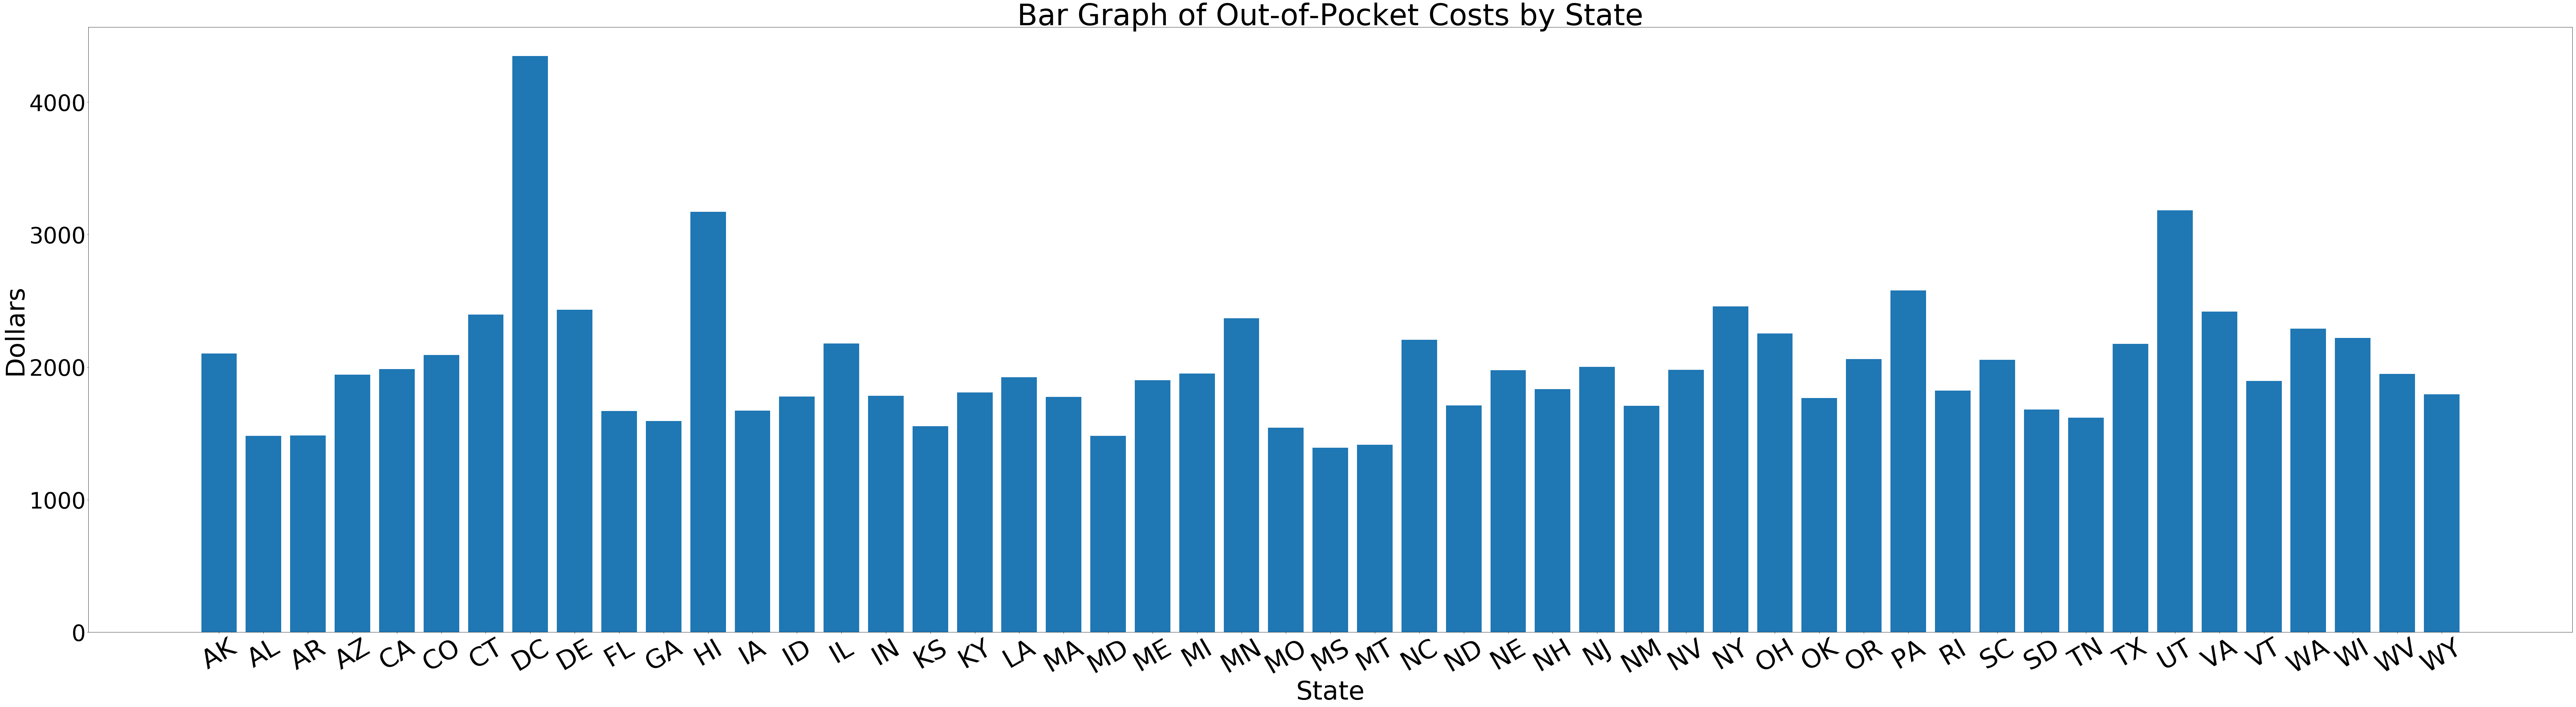

In [139]:
plt.figure(5, figsize=(120,30))
x_axis = np.arange(0,51)

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, list(merge_table["provider_state"]), 
           size=70, rotation=30)
plt.yticks(size=60)
plt.xlabel("State", size=70)
plt.ylabel("Dollars", size=70)
plt.title("Bar Graph of Out-of-Pocket Costs by State", size=80)

# Show graph
plt.bar(x_axis, merge_table["average_patient_payment"])

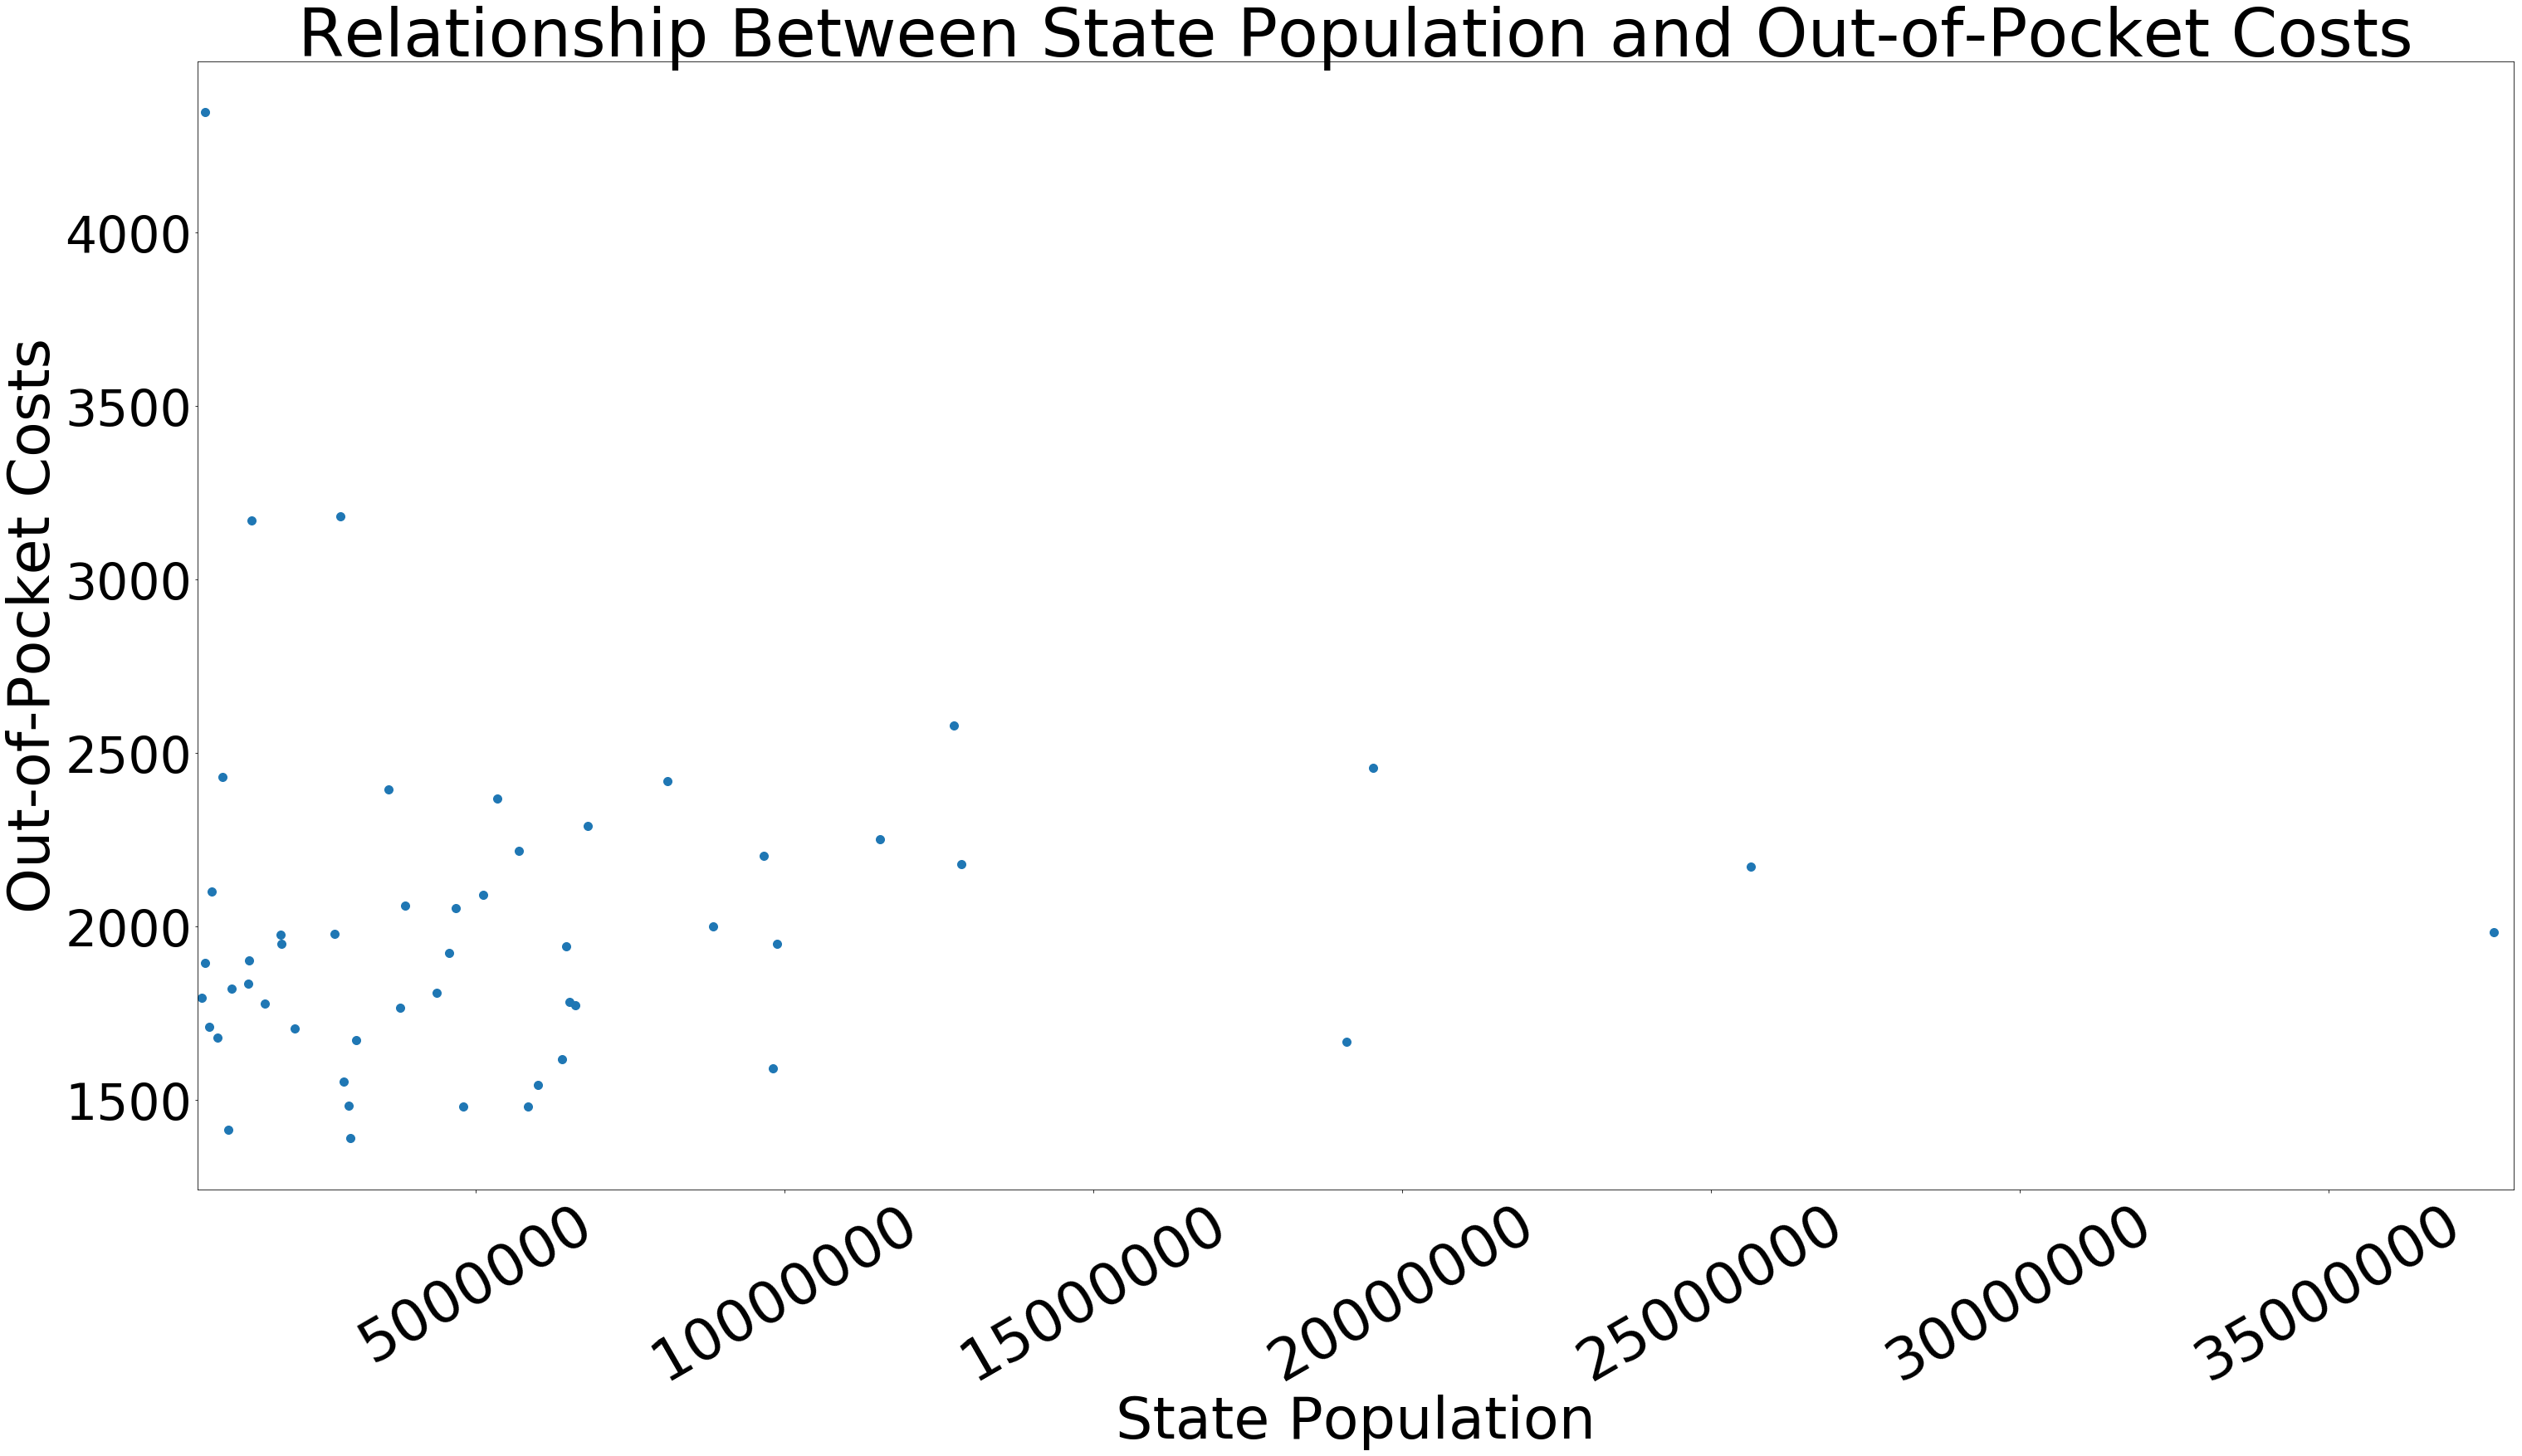

In [140]:
plt.figure(5, figsize=(50,25))
# x_axis = np.arange(0,51)

# Set the upper and lower limits of our x axis
plt.xlim(500000,38000000)
# plt.xlim(500000,5000000000)
# plt.xticks(size=70, rotation=30, format(","))
plt.xticks(size=70, rotation=30)
plt.yticks(size=60)
plt.xlabel("State Population", size=70)
plt.ylabel("Out-of-Pocket Costs", size=70)
plt.title("Relationship Between State Population and Out-of-Pocket Costs", size=80)

plt.ticklabel_format(style='plain')
# Show graph
plt.scatter(merge_table[2011], merge_table["average_patient_payment"], s=100)

# Avg Cost of Procedure in each state(John)

In [19]:
zip_l = main_df.head(1)
ttld_l = main_df['total_discharges'].tolist()
amp_l = main_df['average_medicare_payments'].tolist()
atp_l = main_df['average_total_payments'].tolist()
tmp_l = [i*j for i,j in zip(ttld_l,amp_l)]
ttp_l = [i*j for i,j in zip(ttld_l,atp_l)]
main_df['total_medicare_payments']=tmp_l
main_df['total_total_payments']=ttp_l
#main_df = main_df.drop(['total_medicare_payments','total_total_payments'],axis=1)
main_df.head(1)

,average_covered_charges,average_medicare_payments,average_total_payments,drg_definition,hospital_referral_region_hrr_description,provider_city,provider_id,provider_name,provider_state,provider_street_address,provider_zip_code,total_discharges,total_medicare_payments,total_total_payments
0,1014783.45,141193.91,171081.18,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,AL - Birmingham,BIRMINGHAM,10033,UNIVERSITY OF ALABAMA HOSPITAL,AL,619 SOUTH 19TH STREET,35233,11,1553133.01,1881892.98


In [46]:
#main_df['ACC'].groupby(main_df['Provider State']).head()
#state_office = df.groupby(['state', 'office_id']).agg({'sales': 'sum'})
#main_df.rename(columns = {list(main_df)[8]: 'TtlDis'}, inplace = True)
df_costs_state = main_df.groupby(['provider_state']).\
                    aggregate({'total_medicare_payments':'sum',\
                              'total_total_payments':'sum',\
                              'total_discharges':'sum'})
oop = [(i-j)/k for i,j,k in zip(df_costs_state['total_total_payments'].tolist(),\
                                df_costs_state['total_medicare_payments'].tolist(),\
                                df_costs_state['total_discharges'].tolist())]
df_costs_state['oop']=oop
df_costs_zip = main_df.groupby(['provider_zip_code']).\
                    aggregate({'total_medicare_payments':'sum',\
                              'total_total_payments':'sum',\
                              'total_discharges':'sum'})
oop = [(i-j)/k for i,j,k in zip(df_costs_zip['total_total_payments'].tolist(),\
                                 df_costs_zip['total_medicare_payments'].tolist(),\
                                 df_costs_zip['total_discharges'].tolist())]
df_costs_zip['oop']=oop
df_costs_zip.head(2)

,total_medicare_payments,total_total_payments,total_discharges,oop
provider_zip_code,,,,
1040,10431314.37,11722302.02,1347,958.416964
1060,15427147.31,17876342.79,1942,1261.171720


# Comparing procedure costs vs income in zip code(John)

In [21]:
main_df.head(2)
df_zip = main_df.groupby(['provider_zip_code']).\
            aggregate({'average_covered_charges':'sum',\
                       'average_medicare_payments':'sum',\
                       'average_total_payments':'sum','total_discharges':'sum'})
df_zip.head(2)

,average_covered_charges,average_medicare_payments,average_total_payments,total_discharges
provider_zip_code,,,,
1040,545604.60,370522.22,418877.08,1347
1060,1248497.52,492525.67,560581.35,1942


In [51]:
import pickle
def strip_bins(df_tup):
    med = [12500.0,37500.0,62500.0,87500.0,150000.0,250000.0]
    for idx,df in enumerate(df_tup):
        zip_     = df['zip'].tolist()
        ttlR     = df['TtlR'].tolist()
        ttlJR    = df['TtlJR'].tolist()
        ttlEld   = df['Eld'].tolist()
        if idx == 0:
            # [[zip,ttlPpl,sumAGI,ttlEld]]
            result = [[i,j+k,(j+k/2.0)*med[idx],l] for i,j,k,l \
                      in zip(zip_,ttlR,ttlJR,ttlEld)]
            tmp = df['total_medicare_payments'].tolist()
            ttp = df['total_total_payments'].tolist()
            tdis = df['total_discharges'].tolist()
            oop = df['oop'].tolist()
        for idx0,l in enumerate(result):
            l[1]=l[1]+ttlR[idx]+ttlJR[idx]
            l[2]=l[2]+(ttlR[idx]+ttlJR[idx]/2.0)*med[idx]
            l[3]=l[3]+ttlEld[idx]
    (zip_,ttlPpl,sumAGI,avgAGI,pEld,ttlEld)=[],[],[],[],[],[]
    for i in result:
        zip_.append(i[0])
        ttlPpl.append(i[1])
        sumAGI.append(i[2])
        avgAGI.append(i[2]/i[1])
        pEld.append((i[3]/i[1])*100.0)
        ttlEld.append(i[3])
    df = pd.DataFrame({'ttl_dis':tdis,'tmp':tmp,'ttp':ttp,'oop':oop,'zip':zip_,'ttlPpl':ttlPpl,'sumAGI':sumAGI,'avgAGI':avgAGI,\
                       'pEld':pEld,'ttlEld':ttlEld})
    return(df)
        
new_idx = [i for i in range(0,df_costs_zip.shape[0])]
zc_v = df_costs_zip.index.tolist()
df_costs_zip['idx']=new_idx
df_costs_zip['zip']=zc_v
df_costs_zip.set_index('idx',inplace=True)
df_costs_zip.head(1)

,total_medicare_payments,total_total_payments,total_discharges,oop,zip
idx,,,,,
0,10431314.37,11722302.02,1347,958.416964,0


In [48]:
#merged_##K columns are: average_covered_charges, average_medicare_payments,
#                       average_total_payments,total_discharges,zip,ST,AGI,TtlSR,TtlJR,Eld
merged_25K  = pd.merge(df_costs_zip,df_zip_25K,on='zip',how='inner')
merged_50K  = pd.merge(df_costs_zip,df_zip_50K,on='zip',how='inner')
merged_75K  = pd.merge(df_costs_zip,df_zip_75K,on='zip',how='inner')
merged_100K = pd.merge(df_costs_zip,df_zip_100K,on='zip',how='inner')
merged_200K = pd.merge(df_costs_zip,df_zip_200K,on='zip',how='inner')
merged_1M   = pd.merge(df_costs_zip,df_zip_1M,on='zip',how='inner')
df_tuple = (merged_25K,merged_50K,merged_75K,merged_100K,merged_200K,merged_1M)
df_agi = strip_bins(df_tuple)
df_agi.to_pickle('df_agi.pkl')

In [50]:
df_agi.head(2)


,avgAGI,oop,pEld,sumAGI,tmp,ttlEld,ttlPpl,ttl_dis,ttp,zip
0,39492.218282,958.416964,14.893617,1.002312e+09,10431314.37,3780.0,25380.0,1347,11722302.02,1040
1,46673.086481,1261.171720,15.705765,9.390625e+08,15427147.31,3160.0,20120.0,1942,17876342.79,1060


# Data Exploration

## Dutch

In [76]:
x = input("Would you like to re-load main_df again?")
if x == 'Y':
    main_df = pd.read_csv("main data cleaned.csv")


Would you like to re-load main_df again?Y


In [77]:
# Unique DRG definitions
main_df["drg_definition"].nunique()

563

In [78]:
# Unique HRR Descriptions
main_df["hospital_referral_region_hrr_description"].nunique()

306

In [79]:
# Unique providers
main_df["provider_id"].nunique()# Unique states (including the federal district D.C. (Washington D.C.))
main_df["provider_state"].nunique()

51

In [80]:
# Providers per state
x = main_df.groupby("provider_state")["provider_id"].nunique()
x.head(2)

provider_state
AK     8
AL    83
Name: provider_id, dtype: int64

In [1]:
# US state map

"""Added two columns:
- Deficit, this is the difference between billed to and received from Medicare
- Payment difference, this is the difference between average total payments and average Medicare payments
"""

## Total ACC, ATP and AMP by provider state
state_totals_df = main_df.groupby("provider_state", as_index = False).agg({"provider_id":"nunique",
                                                                           "average_covered_charges":"sum",
                                                                           "average_medicare_payments":"sum",
                                                                           "average_total_payments":"sum"})

state_totals_df["Payment difference"] = state_totals_df["average_total_payments"]-\
                                              state_totals_df["average_medicare_payments"]
state_totals_df["Deficit"] = state_totals_df["average_covered_charges"]-state_totals_df["average_medicare_payments"]

cols = ["average_covered_charges","average_medicare_payments","average_total_payments",
        "Payment difference","Deficit"]

state_totals_df[cols] = round(state_totals_df[cols]/1000000,2)
 
state_totals_df = state_totals_df.rename(columns={"provider_state":"State",
                                                  "provider_id":"Total providers",
                                                  "average_covered_charges":"ACC Total",
                                                  "average_medicare_payments":"AMP Total",
                                                  "average_total_payments":"ATP Total"
                                                 })

state_totals_df.head()

for col in state_totals_df.columns:
    state_totals_df[col] = state_totals_df[col].astype(str)
state_totals_df.to_pickle('state_totals_df.pkl') #added by john 4/16/18 for main_plots notebook

NameError: name 'main_df' is not defined

In [63]:
scl = [[0.0, "rgb(242,240,247)"],[0.2, "rgb(218,218,235)"],[0.4, "rgb(188,189,220)"],
            [0.6, "rgb(158,154,200)"],[0.8, "rgb(117,107,177)"],[1.0, "rgb(84,39,143)"]]

In [64]:
state_totals_df["text"] = "Providers/state: " + state_totals_df["Total providers"] + "<br>" +\
    "ACC "+state_totals_df["ACC Total"]+"<br>"+"AMP "+state_totals_df["AMP Total"]+"<br>"+\
    "ATP "+state_totals_df["ATP Total"]

In [65]:
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_totals_df["State"],
        z = state_totals_df["Deficit"].astype(float),
        locationmode = 'USA-states',
        text = state_totals_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(40,40,40)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Millions USD")
        ) ]

layout = dict(
        title = '2015 US Medicare inpatient charges and payments by state<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

In [66]:
state_totals_df.head()

,State,Total providers,ACC Total,AMP Total,ATP Total,Payment difference,Deficit,text
0,AK,8,19.68,4.48,5.03,0.55,15.2,Providers/state: 8<br>ACC 19.68<br>AMP 4.48<br...
1,AL,83,214.05,36.72,43.11,6.39,177.33,Providers/state: 83<br>ACC 214.05<br>AMP 36.72...
2,AR,44,97.79,22.51,26.26,3.74,75.27,Providers/state: 44<br>ACC 97.79<br>AMP 22.51<...
3,AZ,59,214.21,40.51,47.22,6.71,173.7,Providers/state: 59<br>ACC 214.21<br>AMP 40.51...
4,CA,294,1476.42,229.5,259.49,29.99,1246.92,Providers/state: 294<br>ACC 1476.42<br>AMP 229...


In [67]:
# Average Medicare Payments as percentage of Average Covered Charges
# Totalize by DRG and group by state

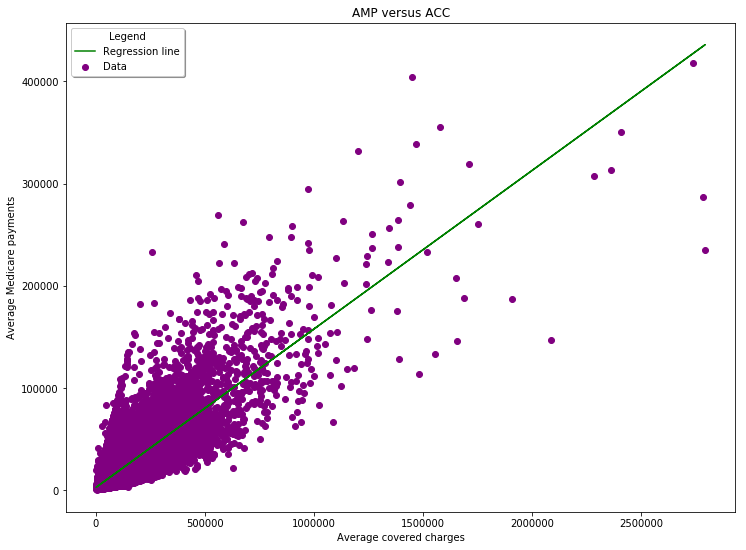

In [68]:
"""
Average Covered Charges plotted against Average Medicare Payments.
ACC and AMP are compared and a regression line is created.
Regression tell whether above data is correlated ("is there a linear relationship between the data)
"""

corr_df = main_df[["average_covered_charges","average_medicare_payments"]]

x_vals = corr_df["average_covered_charges"]
y_vals = corr_df["average_medicare_payments"]

# Grab linear regression data
slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)

# Plot data
fig, ax = plt.subplots()

plt.scatter(x_vals, y_vals, color = "purple", label="Data")

ax.set_xlabel("Average covered charges")
ax.set_ylabel("Average Medicare payments")
ax.set_title("AMP versus ACC")

# Plot regression line
plt.plot(x_vals, intercept + slope*x_vals, color = "green", label="Regression line")

# Set plot size
plt.rcParams["figure.figsize"] = [12,9]

# Define legend
plt.legend(loc="best", ncol=1, shadow=True, title="Legend", fancybox=True)

plt.show()

In [69]:
"""Are Average Covered Charges and Average Medicare Payments related?

Above regression line indicates that Average Covered Charges and Average Medicare Payments are related.
We want to find it whether that might be true.
In order to do so, we're gonna assume the opposite (they are not related) and see if we can reject this assumption.

NULL HYPOTHESIS:

"Average Covered Charges are NOT related to Average Medicare Payments"

If we can reject this null hypothesis, it means that the data is indeed related.

Check null hypothesis:

- measure the slope s of the best fit line between Average Cost Charged and Average Medicare Payments
- determine the probability of measuring a slope S if the slope is actually zero
- Compute p=Pr(S>|s|) -> probability of measuring a slope S if the slope is actually zero
- p_value < 0.05 -> null hypothesis is rejected
- reject the idea of a zero slope if p is small

Results:
slope is: 0.15501347856099176
intercept is: 2686.826201857424
coefficient is: 0.8288605612536292
R-squared is: 0.6870098300016811
p_value is: 0.0

R-squared (the square of the correlation coefficient) can range from -1 to +1
-1 indicates no correlation, +1 indicates a high correlation
In our case, R-squared is 0.68 which indicates a pretty strong correlation
Trend (coeeficient) is quite high so we will reject our null hypothesis.
There indeed is a linear relationship between Average Cost Charged and Average Medicare Payments.

REMARK: WE MIGHT WANT TO ZOOM IN ON THE SCATTER PLOT
"""

slope, intercept, rvalue, pvalue, stderr = linregress(x_vals, y_vals)
print(f"slope is: {slope}")
print(f"intercept is: {intercept}")
print(f"coefficient is: {rvalue}")
print(f"R-squared is: {rvalue**2}")
print(f"p_value is: {pvalue}")

slope is: 0.15501347856099237
intercept is: 2686.8262018573914
coefficient is: 0.8288605612536311
R-squared is: 0.6870098300016843
p_value is: 0.0


In [70]:
# Some double checked on the value found for coefficient:
a = corr_df.corr()
b = np.corrcoef(corr_df["average_medicare_payments"], corr_df["average_covered_charges"])
c = 0.828860561 #value found using MS Excel
print(a, "\n", b, "\n", c)

                           average_covered_charges  average_medicare_payments
average_covered_charges                   1.000000                   0.828861
average_medicare_payments                 0.828861                   1.000000 
 [[ 1.          0.82886056]
 [ 0.82886056  1.        ]] 
 0.828860561
